In [788]:
import pandas as pd
import os, glob
import soundfile
import librosa
import numpy as np
from librosa import display
import IPython.display as ipd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import accuracy_score,classification_report,precision_recall_fscore_support,f1_score

In [789]:
dir_list = os.listdir('dataset')
dir_list.sort()
print (dir_list)

['person_01', 'person_02', 'person_03', 'person_04', 'person_05', 'person_06', 'person_07', 'person_08', 'person_09', 'person_10', 'person_11', 'person_12', 'person_13', 'person_14', 'person_15', 'person_16', 'person_17', 'person_18', 'person_19', 'person_20', 'person_21', 'person_22', 'person_23', 'person_24']


In [790]:
data_df = pd.DataFrame(columns=['path', 'source', 'person', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('dataset/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'dataset/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [791]:
print (len(data_df))
data_df.head()

1440


,path,source,person,gender,intensity,statement,repetition,emotion
0,dataset/person_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1
1,dataset/person_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1
2,dataset/person_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1
3,dataset/person_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1
4,dataset/person_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2


In [792]:
filename = data_df.path[1001]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

dataset/person_17/03-01-06-02-01-02-17.wav


(22050,
 array([ 5.8864880e-05,  9.3958472e-05,  7.8879741e-05, ...,
        -2.1121369e-07, -9.5763404e-08,  0.0000000e+00], dtype=float32))

In [793]:
len(samples), sample_rate

(82403, 22050)

In [794]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

# Plotting Wave Form and Spectrogram

Text(0.5, 0, 'Seconds')

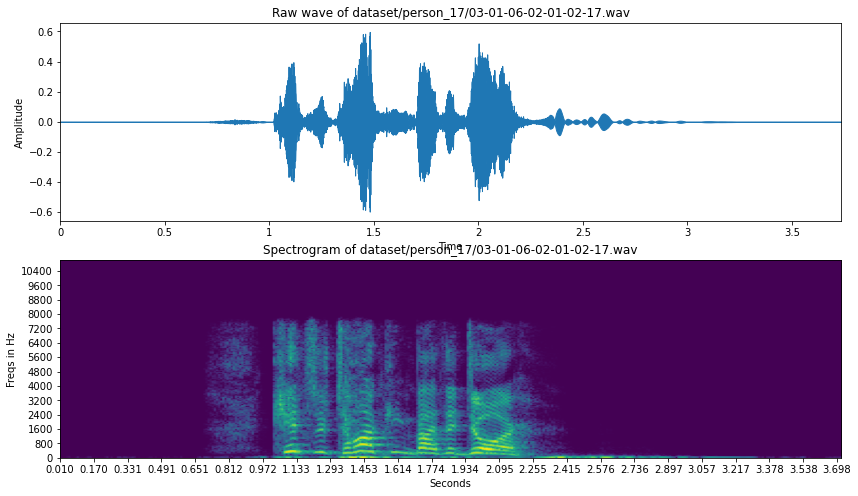

In [795]:


freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [796]:
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([ 3.0313837e-04,  1.3649819e-04,  2.5525806e-06, ...,
        -4.3952540e-03, -4.4225845e-03, -4.4452017e-03], dtype=float32),
 array([22016, 61440]))

# Plotting Mel Power Spectrogram


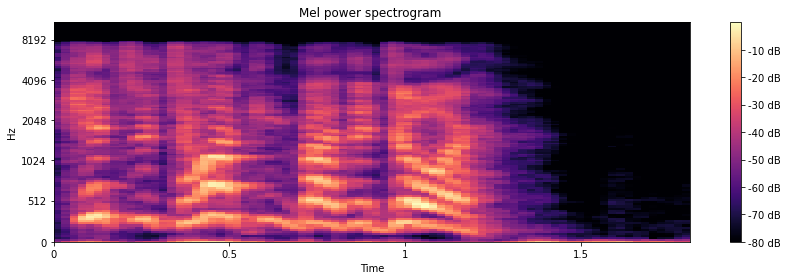

In [797]:

S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Plotting MFCC

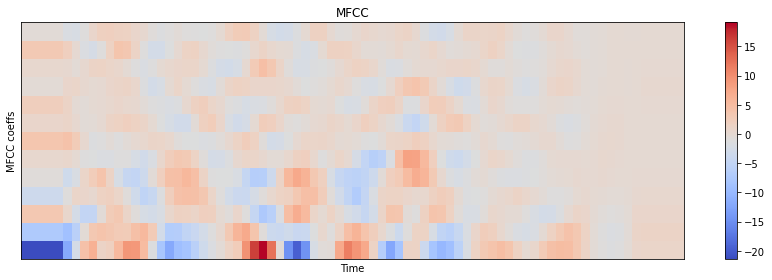

In [798]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [745]:
ipd.Audio(samples, rate=sample_rate)

In [746]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [799]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [748]:

dataset_emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

search_emotions=['calm',
                 'happy',
                 'fearful',
                 'disgust',
                 'angry' ]

# Load the data and extract features for each sound file

In [800]:

def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("dataset\\person_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=dataset_emotions[file_name.split("-")[2]]
        if emotion not in search_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

# Spliting the dataset

In [801]:
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

In [802]:
x_train


array([[-4.91142059e+02,  2.55316238e+01, -1.04814377e+01, ...,
         1.14909746e-03,  4.10828128e-04,  2.51000951e-04],
       [-7.18250977e+02,  3.15797539e+01,  3.41552973e+00, ...,
         4.00241734e-05,  3.25012552e-05,  1.94277400e-05],
       [-4.69942657e+02,  3.02186203e+01, -2.09227753e+01, ...,
         3.61918152e-04,  1.96826426e-04,  8.83359680e-05],
       ...,
       [-4.81092377e+02,  4.40312347e+01, -1.54046221e+01, ...,
         1.78873728e-04,  1.06643281e-04,  7.36320653e-05],
       [-5.19665100e+02,  4.49676704e+01, -1.71920002e+00, ...,
         9.56963704e-05,  4.96343710e-05,  2.71927820e-05],
       [-3.91129730e+02,  9.70392799e+00, -2.87967777e+01, ...,
         9.71957576e-03,  4.88202320e-03,  1.43602106e-03]])

# to find the shape of the training and testing datasets

In [803]:
print((x_train.shape[0], x_test.shape[0]))

(460, 116)


# To find the number of features extracted from the dataset 

In [769]:
print('Features extracted:' , x_train.shape[1])

Features extracted: 180


# Using Multi Layer Perceptron Classifier

In [804]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,),
                    learning_rate='adaptive', max_iter=500)

# Training the model with multi layer perceptron classifier

In [805]:
model.fit(x_train,y_train)

C:\Users\sreej\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

# Prediction for the test set

In [806]:
y_prediction=model.predict(x_test)

In [807]:
#y_test

In [808]:
y_pre=list(y_prediction)

In [775]:
res_check = pd.DataFrame({'Actual': y_test , 'Predicted':y_pre})
print(res_check.head(20))

     Actual Predicted
0   fearful   fearful
1   fearful   fearful
2   fearful   fearful
3      calm      calm
4      calm      calm
5      calm      calm
6      calm      calm
7      calm      calm
8   fearful      calm
9      calm      calm
10     calm     happy
11  fearful   fearful
12    happy     happy
13     calm      calm
14  fearful      calm
15     calm      calm
16    happy     happy
17     calm     happy
18    happy     happy
19  fearful   fearful


# Calculation of Accuracy

In [809]:
accuracy=accuracy_score(y_test, y_prediction)

In [810]:
print("Accuracy: {:.1f}%".format(accuracy*100))

Accuracy: 82.8%


In [811]:
c= classification_report(y_test,y_prediction)
print(c)

              precision    recall  f1-score   support

        calm       0.88      0.95      0.91        38
     fearful       0.85      0.76      0.80        46
       happy       0.74      0.78      0.76        32

    accuracy                           0.83       116
   macro avg       0.82      0.83      0.82       116
weighted avg       0.83      0.83      0.83       116



In [812]:
f=f1_score(y_true=y_test, y_pred=y_prediction , average=None)
print(f)


[0.91139241 0.8045977  0.75757576]


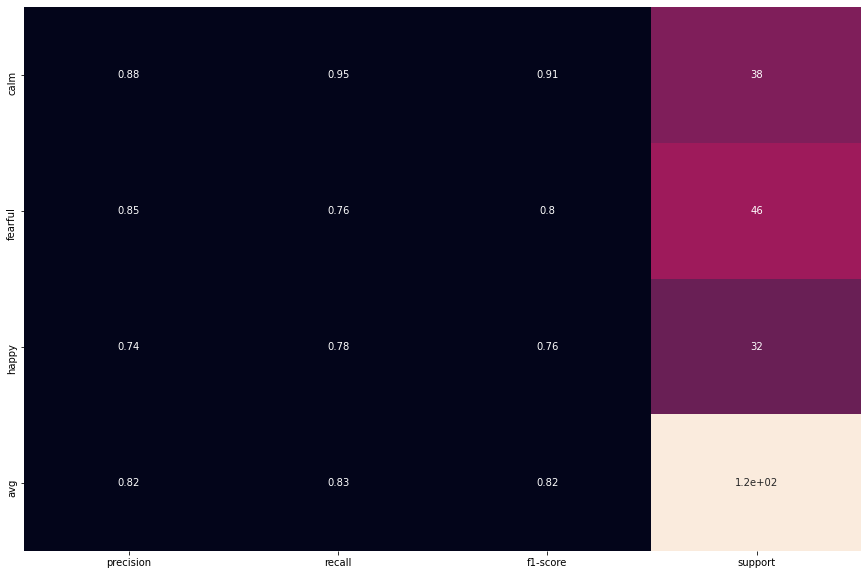

In [813]:
def plot_classification_report(y_tru, y_prd, figsize=(15, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)

plot_classification_report(y_test, y_prediction)
